<h1>Master script to run the one shot analysis of the microbleeds in a single go</h1>
<h3>Intended to be used to collect the target labelled data(CMB patches) from all the subjects and store it as train & test data in a pandas dataframe</h3>

In [1]:
import os
from pfca import init_path
from pfca.visuals.img2D import imgplot

Current Working Directory: /Users/shwetankpanwar/Documents/BTPData/python_scripts/cmb_segmentation
The file structure creation failed. Structure already exists!


In [2]:
from pfca.core.preprocessing import *
from pfca.core.processing import *
from pfca import file_read as f
import ants
import skimage.feature as feature
from time import time
from pfca.exp.results import roi_snipping

In [3]:
from pfca.exp.dataset import *

In [4]:
raw_dir, nifti_dir = init_path()
cur_path = os.getcwd()
patients_list = f.get_immediate_subdirectories(raw_dir)

In [5]:
dataset = dataset_management()

In [6]:
#testing for template exclusion idea for anatomical exclusion to reduce search space
talariach = ants.image_read(cur_path + '/datasets/talairach.nii')
mni_t2 = ants.image_read(cur_path + '/datasets/mni_t2_template.nii')
harvard_atlas = ants.image_read(cur_path + '/datasets/harvard_atlas.nii')

In [7]:
#Registering Harvard-Oxford Atlas with MNI-152 template using non-linear registration
harvard_mni = mni_template_registration(cur_path,harvard_atlas,'harvard')
#generating cortex mask from the atlas excluding all the regions of cerebrum 
harvard_mni_mask = ((harvard_mni.numpy()) > 0)*1

In [8]:
patients_list

['p2', 'p1']

In [9]:
print("Data preprocesssing begins...")
for patient in patients_list:
    file_list = f.dcm_lst(raw_dir+patient)
    eswan_list = f.get_label_based_list(file_list,'eSWAN')
    img_eSWAN = f.extract_dcm_array(eswan_list)
    dcm_to_nifti(img_eSWAN,patient, nifti_dir, eswan_list, 
             rotation = True)
    skull_stripping(nifti_dir,patient+'_conv')
    print("/n")

Data preprocesssing begins...
Subject Name(For research purposes) :IQUEBAL
Array Dimensions:
(512, 512, 68)
p2 nifti file generated successfully with the metadata provided.


KeyboardInterrupt: 

In [9]:
for patient in patients_list:
    print("\n RST processing on " + str(patient) + " initiated!")
    im_nifti = nifti_ANTS(nifti_dir, patient, category = 'eswan', unskulled = True)
    im_patient = mni_template_registration(cur_path, im_nifti, patient)
    #calculating the RST output on the whole image
    img_pat = im_patient.numpy()
    rst_whole = rst_3d(img_pat, 2,2,0.2)
    rst_masked = rst_whole * harvard_mni_mask
    #Extracting the candidate points from the RST output image
    peaks = feature.peak_local_max(rst_masked, min_distance=2,threshold_rel = 0.2)
    snips = roi_snipping(img_pat,peaks,5)
    dataset.append(patient, peaks, snips)
    print("ROIs saved to dataset successfully!")


 RST processing on p2 initiated!
Time taken for 3D RST: 20.665857791900635
ROIs saved to dataset successfully!

 RST processing on p1 initiated!
Time taken for 3D RST: 20.05469799041748
ROIs saved to dataset successfully!


In [10]:
dataset.show()

,RST_peak,image_patch,label,patient_name
0,"[97, 91, 97]","[[[1520.5015, 1569.4806, 1601.607, 1616.3756, ...",NaN,p2
1,"[93, 80, 128]","[[[1512.5273, 1519.9901, 1524.0062, 1534.6393,...",NaN,p2
2,"[84, 74, 85]","[[[1526.3732, 1481.858, 1486.6381, 1509.9438, ...",NaN,p2
3,"[53, 63, 96]","[[[1575.6156, 1599.6085, 1593.7793, 1564.5856,...",NaN,p2
4,"[135, 100, 91]","[[[1719.8491, 1681.455, 1653.2905, 1628.386, 1...",NaN,p1
5,"[62, 104, 58]","[[[1569.3444, 1493.1567, 1404.4259, 1315.8666,...",NaN,p1


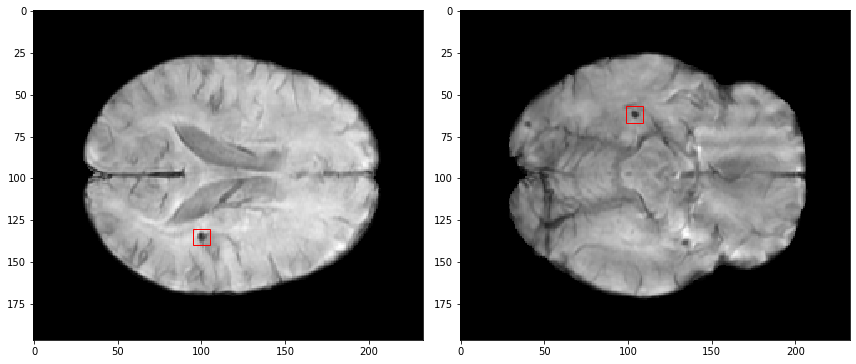

In [11]:
dataset.disp_roi('p1')

In [12]:
#dataset.disp_roi('p2')
datafile = dataset.show()
datafile.to_pickle('rst_output') 

In [10]:
import pandas as pd
data = pd.read_pickle('rst_output')

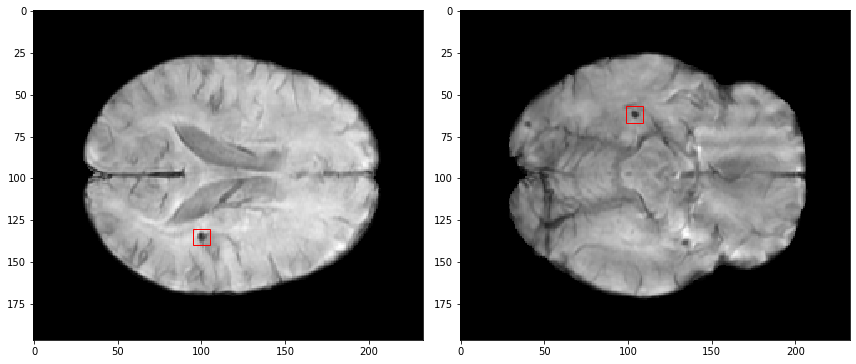

In [20]:
t = dataset_management()
t.dataset = data
t.disp_roi('p1')

In [11]:
total_data = pd.read_pickle('rst_output_aall_subjects_2_2_0.1')

FileNotFoundError: [Errno 2] No such file or directory: 'rst_output_all_subjects_2_2_0.1'

In [10]:
total_data

,RST_peak,image_patch,label,patient_name
0,"[171, 103, 87]","[[[1604.2019, 1612.2238, 1584.8153, 1550.3676,...",NaN,12
1,"[171, 97, 61]","[[[1151.8575, 1269.8489, 1393.6145, 1520.887, ...",NaN,12
2,"[170, 121, 58]","[[[1769.2383, 1805.1096, 1834.2352, 1837.5428,...",NaN,12
3,"[170, 117, 71]","[[[1762.8202, 1846.0253, 1921.8511, 1976.3429,...",NaN,12
4,"[170, 102, 53]","[[[710.26697, 800.9684, 878.76276, 935.9742, 9...",NaN,12
5,"[170, 91, 84]","[[[1851.205, 1951.2527, 1994.4828, 1983.8191, ...",NaN,12
6,"[169, 115, 97]","[[[1621.4022, 1678.7334, 1741.5708, 1791.8369,...",NaN,12
7,"[168, 115, 105]","[[[1761.327, 1798.1428, 1875.3728, 1971.9221, ...",NaN,12
8,"[168, 112, 88]","[[[1596.7714, 1608.4497, 1636.7616, 1668.0872,...",NaN,12
9,"[168, 83, 73]","[[[2091.7402, 2410.6912, 2583.867, 2566.7422, ...",NaN,12


In [39]:
total_data.loc[total_data['patient_name'] == '5']

,RST_peak,image_patch,label,patient_name
766,"[139, 142, 67]","[[[2553.3855, 2612.0293, 2648.8555, 2673.9736,...",NaN,5
767,"[94, 167, 119]","[[[1699.5485, 1655.255, 1731.7466, 1842.4784, ...",NaN,5


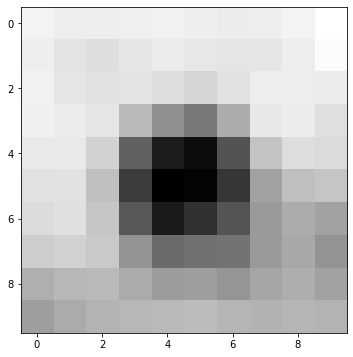

In [40]:
imgplot(total_data.iloc[766]['image_patch'], slice_no=[5])